In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Packages form Henriks Github
from lammps_logfile import running_mean, get_color_value
from regex_file_collector import Collector
from regex_file_collector.utils import floating_number_pattern
import lammps_logfile

In [2]:
path = '/home/users/marthgg/2021_08_quartz_simulations'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

logFileFolder = '/home/users/marthgg/2021_08_quartz_simulations'

The pattern contains 1 capturing groups
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.025391/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.037500/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.023591/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.011000/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.018000/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.027194/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.050000/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.043812/fracture_displacement.npy
/home/users/marthgg/2021_08_quartz_simulations/crack_simulation_deformZ_1.03499/fracture_displacement.np

In [3]:
def findVelocity(filename, timestep, dump_frequency):
    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))

    filtered_data_crackTip = []
    filtered_data_frames   = []

    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])            
    
    for i in range(0, len(filtered_data_frames)):
        if filtered_data_crackTip[i] > 2910:
            break

    # Find velocity
    timestep = timestep # ps
    dump_frequency = dump_frequency

    time_s = []
    time = []
    for i in range(0, len(filtered_data_frames)):
        time.append(filtered_data_frames[i]*timestep*dump_frequency) #Time in ps
        if filtered_data_crackTip[i] < 2910:
            time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        if filtered_data_crackTip[i] < 2910:
            position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

    velocity = np.diff(position_m)/np.diff(time_s)
    
    return velocity

982.2616234905984


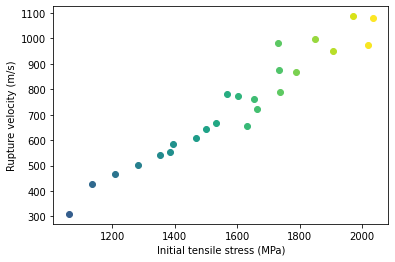

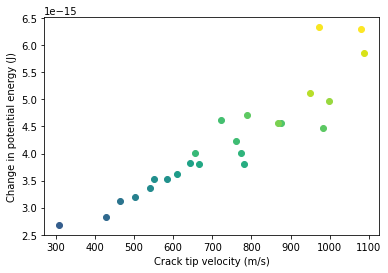

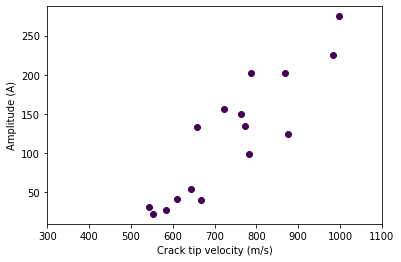

In [8]:
system_length = 3000
crack_start_point = 150

timestep = 0.001
dump_frequency = 10000

amplitude = [31.296,    22.1023,   27.5269,   41.4021,   53.3189,   39.888,    98.4374,   135.111,   133.392,  149.439, 155.971,   124.731,   224.863,   202.471,   202.153,   274.817] #Å
deformZ_amp   = ['1.029000', '1.029806', '1.030000', '1.031994', '1.032990', '1.033992', '1.03499', '1.035994', '1.036997', '1.037500', '1.038000', '1.038927', '1.039854', '1.040000', '1.041904', '1.043812']  

for deformZ, path in simulations.items():
    filename = path
    
    velocity = findVelocity(filename, timestep, dump_frequency)
    
    mean_velocity = np.mean(velocity)
    
    if deformZ == '1.039854':
        print(mean_velocity)
    
    logfile = os.path.join(logFileFolder, 'crack_simulation_deformZ_%s/log.lammps') %deformZ

    log = lammps_logfile.File(logfile)
    pzz = log.get('Pzz')
    min_pressure = np.min(pzz)
    
    potEng = log.get('PotEng')
    time = log.get('Time')
    
    plt.figure(1)
    plt.plot((min_pressure/10)*-1, mean_velocity, 'o', color=get_color_value(float(deformZ), 1.010000, 1.050000))
    plt.xlabel('Initial tensile stress (MPa)')
    plt.ylabel('Rupture velocity (m/s)')
    
    min_pot = np.min(potEng)
    pot = potEng[200:]
    min_pot_crack = np.min(pot[100:])
    
    delta_up = min_pot_crack - min_pot #eV
    delta_up_J = delta_up * 1.60218e-19 #Joules

    plt.figure(2)
    plt.plot(mean_velocity, delta_up_J, 'o', color=get_color_value(float(deformZ), 1.010000, 1.050000))
    plt.ylabel('Change in potential energy (J)')
    plt.xlabel('Crack tip velocity (m/s)')
    
    if deformZ in deformZ_amp:
        index = deformZ_amp.index(deformZ)
        plt.figure(3)
        plt.plot(mean_velocity, amplitude[index], 'o', color=get_color_value(float(deformZ), 1.045000, 1.05000))
        plt.ylabel('Amplitude (A)')
        plt.xlabel('Crack tip velocity (m/s)')
        plt.xlim([300, 1100])
        